### Install dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
mydir = "/content/drive/MyDrive/KMUTT/CPE393_TextAnalytics/Lab/text_clustering"
os.chdir(mydir)
!ls

main.ipynb  menuitems.csv  requirements.txt


In [3]:
%pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [4]:
import re
import pandas as pd
import numpy as np

from sentence_transformers import SentenceTransformer

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from matplotlib import pyplot as plt

from collections import Counter

### Read data from CSV

In [5]:
DATA = 'menuitems.csv'
df = pd.read_csv(DATA)
print(df.describe())

       Restaurant Name     Original food Item
count             4524                   4524
unique             341                   4330
top        Happy Joe's  Chocolate Chip Cookie
freq                48                     11


In [7]:
# Dataframe columns:
RESTAURANT = 'Restaurant Name'
ITEM = 'Original food Item'
EMBEDDING = 'Embedding'
CLUSTER = 'Cluster'

### Data cleaning

Very basic, remove non-alphabetic characters and measure like fl oz and inch

In [8]:
def clean_item(item):
    # Remove these measures as they are creating spurious clusters
    rem = ['oz', 'fl', 'inch']
    for r in rem:
        p = r'\b' + re.escape(r) + r'\b'
        item = re.sub(p, '', item, flags=re.IGNORECASE)

    # Keep only alphabetical characters
    item = re.sub(r'[^a-zA-Z\s]', '', item)

    return item

df[ITEM] = df[ITEM].apply(lambda x: clean_item(x))

### Create sentence embeddings for menu items

Using sentence-transformers library and a popular BERT based model from Hugging Face to generate the vector representations of the menu items.

In [9]:
bert = 'bert-base-nli-stsb-mean-tokens'

sentence_transformer = SentenceTransformer(bert)
embeddings = sentence_transformer.encode(df[ITEM], show_progress_bar=True)
print(f"Embedding shape: {embeddings.shape}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.01k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/630 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/142 [00:00<?, ?it/s]

Embedding shape: (4524, 768)


### Visualize embeddings

Visualize the embedding of the menu items using t-SNE. Couldn't see any clearly separated clusters in 2D using PCA, it was only capturing ~30% of the variance. So tried t-SNE, which shows more clearly separated clusters.

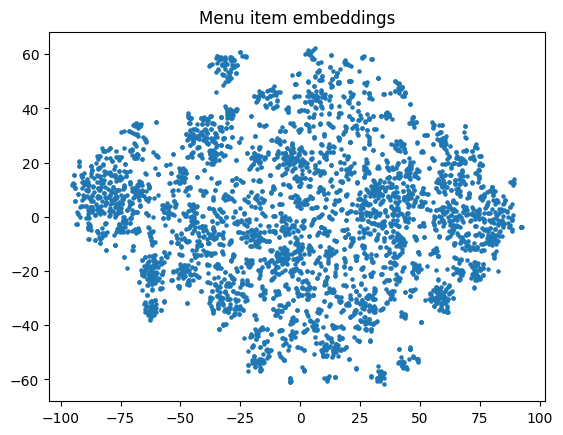

In [10]:
def visualize_embeddings(embeddings, size=10, labels=None, title=''):
    tsne = TSNE(n_components=2, learning_rate='auto')
    tsne_embeddings = tsne.fit_transform(embeddings)

    plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], s=size, c=labels)
    plt.title(title)
    plt.show()

visualize_embeddings(embeddings, size=5, title='Menu item embeddings')

### Dimensionality reduction using PCA

Use PCA to reduce dimensionality while retaining 90% of variance in data.

In [11]:
pca = PCA(n_components=0.9, svd_solver='full')
dim_reduced_embeddings = pca.fit_transform(embeddings)
print(f"Dimension reduced embedding shape: {dim_reduced_embeddings.shape}")

df[EMBEDDING] = list(dim_reduced_embeddings)

Dimension reduced embedding shape: (4524, 119)


### Vector Representation of restaurants

Average the vectors of the menu items of each restaurant to create a vector representation of the restaurant.

In [12]:
restaurant_df = df.drop(columns=[ITEM])
restaurant_df = restaurant_df.groupby(RESTAURANT).mean().reset_index()

### Find the best number of clusters

Use silhouette score (higher the better) to find the best k.

https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient

Silhouette scores: {5: 0.06449328, 6: 0.063979365, 7: 0.084176436, 8: 0.059911825, 9: 0.045156717, 10: 0.06548932, 11: 0.06064591, 12: 0.047457397, 13: 0.05899742, 14: 0.03707352, 15: 0.033852242, 16: 0.05206475, 17: 0.053173635, 18: 0.044194255, 19: 0.025753293, 20: 0.054108907, 21: 0.033490837, 22: 0.0522748, 23: 0.02894744, 24: 0.045200113, 25: 0.020842073, 26: 0.07018955, 27: 0.012504544, 28: 0.03771144, 29: 0.046939507}


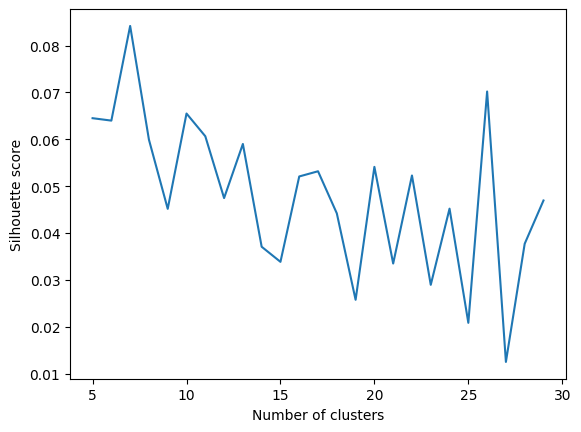

In [13]:
restaurant_embeddings = [embedding for embedding in restaurant_df[EMBEDDING].values]

candidate_k_values = list(range(5, 30))
slht_scores, kmeans_labels = [], []
for k in candidate_k_values:
    kmeans = KMeans(n_clusters=k, n_init=20)
    kmeans.fit(restaurant_embeddings)

    kmeans_labels.append(kmeans.labels_)
    slht_scores.append(silhouette_score(restaurant_embeddings, kmeans.labels_))

silhouette_score_dict = {candidate_k_values[i]: slht_scores[i] for i in range(len(slht_scores))}

print(f"Silhouette scores: {silhouette_score_dict}")

plt.plot(candidate_k_values, slht_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

### Label restaurants with clusters

In [14]:
best_k = 15
restaurant_df[CLUSTER] = kmeans_labels[best_k - candidate_k_values[0]]

### Visualize restaurant clusters

Not very well defined clusters, other than few of them at the edge.

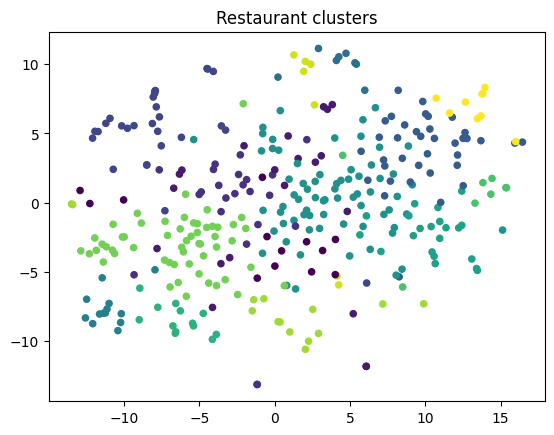

In [15]:
restaurant_embeddings = np.array([embedding for embedding in restaurant_df[EMBEDDING].values])

visualize_embeddings(restaurant_embeddings, size=20, labels=restaurant_df[CLUSTER].values, title='Restaurant clusters')

In [16]:
restaurant_df.sort_values(by=CLUSTER, inplace=True)
restaurant_df.to_csv('restaurants_clustered.csv', index=False, columns=[RESTAURANT, CLUSTER])

### Inspect clusters

Tried to look at what the most common words in the menu items for restaurants in each cluster are.

In [17]:

def most_common_words(x):
    word_salad = ' '.join(x.values).lower().split()
    ctr = Counter(word_salad)

    return ctr.most_common(3)

menuitems_clustered_df = df.merge(restaurant_df, on=RESTAURANT, how='left')
menuitems_clustered_df.groupby(CLUSTER)[ITEM].apply(most_common_words).reset_index()

,Cluster,Original food Item
0,0,"[(tilapia, 3), (fillets, 2), (pita, 2)]"
1,1,"[(sauce, 14), (salsa, 12), (corn, 10)]"
2,2,"[(soup, 29), (dressing, 26), (organic, 19)]"
3,3,"[(shrimp, 40), (salmon, 31), (wild, 25)]"
4,4,"[(cream, 152), (ice, 119), (chocolate, 113)]"
5,5,"[(bread, 7), (rye, 5), (crispbread, 3)]"
6,6,"[(chicken, 100), (breast, 22), (rice, 15)]"
7,7,"[(with, 104), (cheese, 93), (chicken, 90)]"
8,8,"[(smoothie, 34), (kefir, 20), (milk, 17)]"
9,9,"[(beef, 16), (steak, 7), (smoked, 6)]"


### Cluster sizes

Few oddly small clusters (5, 7), and couple of large clusters (4, 13).

Text(0, 0.5, 'Cluster ID')

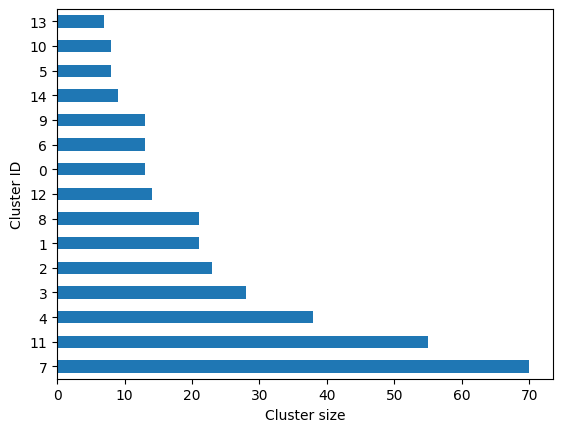

In [18]:
restaurant_df[CLUSTER].value_counts().plot(kind='barh')
plt.xlabel('Cluster size')
plt.ylabel('Cluster ID')